# Анализ целевых показателей и подготовка данных для предсказания токсичности химических соединений

# Анализ целевых показателей и подготовка данных

## Исходные данные и целевые переменные

В рамках данного исследования рассматриваются пять целевых переменных, каждая из которых отражает различные аспекты токсичности малых органических молекул. Эти показатели используются для построения моделей машинного обучения, способных предсказывать токсичность веществ на основе их химической структуры.

### Перечень целевых переменных:

1. **EPA Category**  
   Категориальная переменная, определяющая уровень токсичности согласно классификации Агентства по охране окружающей среды США (Environmental Protection Agency).  
   - **Диапазон значений:** 1 (высокая токсичность) — 4 (низкая токсичность)  
   - **Значимость:** используется для классификации токсичности в экологических стандартах.

2. **GHS Category**  
   Классификация в соответствии с Глобальной гармонизированной системой (Globally Harmonized System of Classification and Labelling of Chemicals).  
   - **Диапазон значений:** от 1 (наиболее токсично) до 5 (наименее токсично)  
   - **Значимость:** общепринятая международная система классификации.

3. **LD50 (мг/кг)**  
   Пороговая доза, вызывающая летальный исход у 50% подопытных животных при однократном введении вещества.  
   - **Тип данных:** непрерывный  
   - **Единицы измерения:** миллиграммы на килограмм массы тела  
   - **Значимость:** количественная оценка токсичности, широко используемая в токсикологических исследованиях.

4. **Нетоксичность (LD50 > 2000 мг/кг)**  
   Бинарная переменная, отражающая принадлежность вещества к классу с низкой токсичностью.  
   - **Значения:** 1 — вещество считается нетоксичным, 0 — иное  
   - **Цель:** выделение безопасных соединений.

5. **Высокая токсичность (LD50 < 50 мг/кг)**  
   Бинарная переменная, выделяющая вещества с крайне высокой токсичностью.  
   - **Значения:** 1 — высокотоксичное вещество, 0 — иное  
   - **Цель:** акцент на особо опасных соединениях.

---


## Импорт необходимых библиотек

Для выполнения анализа и построения моделей машинного обучения используются следующие библиотеки:

- `pandas`, `numpy` — работа с данными и числовыми массивами;
- `rdkit` — обработка химических структур и вычисление дескрипторов;
- `scikit-learn` — предобработка признаков и кодирование категориальных переменных;
- `joblib` — сохранение промежуточных объектов.


In [1]:
import pandas as pd
import numpy as np
import math
import joblib

from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem import PandasTools
from rdkit.Chem import Descriptors
from sklearn.preprocessing import LabelEncoder
from IPython.display import HTML
import base64
from io import BytesIO

Вспомогательные функции для лучшей визуализации метода .head()

In [2]:
def mol_to_img_tag(mol, size=(200, 200)):
    img = Draw.MolToImage(mol, size=size)
    buf = BytesIO()
    img.save(buf, format='PNG')
    data = base64.b64encode(buf.getvalue()).decode()
    return f'<img src="data:image/png;base64,{data}"/>'

In [3]:
def visualised_head(df, n=1, mol_col='ROMol'):
    df_copy = df.head(n).copy()
    df_copy[mol_col] = df_copy[mol_col].apply(mol_to_img_tag)
    return HTML(df_copy.to_html(escape=False))

## Загрузка данных

Данные загружаются из CSV-файлов. В качестве индекса используется столбец `CASRN` — уникальный идентификатор химического вещества согласно Chemical Abstracts Service.


In [4]:
train = pd.read_csv('../data/row/simplified_data/train.csv', index_col = 'CASRN')
test = pd.read_csv('../data/row/simplified_data/test.csv', index_col = 'CASRN')

## Первичный осмотр структуры данных

Выводим первую строку обучающего набора для оценки структуры.

In [5]:
train.head(1)

,EPA_category,GHS_category,LD50_mgkg,nontoxic,very_toxic,SMILES
CASRN,,,,,,
100-00-5,2.0,4.0,460.0,False,False,[O-][N+](=O)C1C=CC(Cl)=CC=1


## Добавление химических структур

Преобразуем SMILES-строки в объекты молекул RDKit (ROMol), необходимые для вычисления молекулярных дескрипторов.

In [6]:
PandasTools.AddMoleculeColumnToFrame(train,smilesCol='SMILES')
PandasTools.AddMoleculeColumnToFrame(test,smilesCol='SMILES')

In [7]:
train.head(1)

,EPA_category,GHS_category,LD50_mgkg,nontoxic,very_toxic,SMILES,ROMol
CASRN,,,,,,,
100-00-5,2.0,4.0,460.0,False,False,[O-][N+](=O)C1C=CC(Cl)=CC=1,<rdkit.Chem.rdchem.Mol object at 0x0000022A73A...


,EPA_category,GHS_category,LD50_mgkg,nontoxic,very_toxic,SMILES,ROMol
CASRN,,,,,,,
100-00-5,2.0,4.0,460.0,False,False,[O-][N+](=O)C1C=CC(Cl)=CC=1,

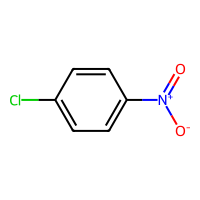

In [8]:
visualised_head(train)

## Вычисление молекулярной массы

Добавляем признак `MW` (Molecular Weight) для каждой молекулы.

In [9]:
train['MW'] = train.apply(lambda x: Descriptors.MolWt(x['ROMol']), axis=1)
test['MW'] = test.apply(lambda x: Descriptors.MolWt(x['ROMol']), axis=1)

Повторный вывод первой строки с уже добавленным значением молекулярной массы.

In [10]:
train.head(1)

,EPA_category,GHS_category,LD50_mgkg,nontoxic,very_toxic,SMILES,ROMol,MW
CASRN,,,,,,,,
100-00-5,2.0,4.0,460.0,False,False,[O-][N+](=O)C1C=CC(Cl)=CC=1,<rdkit.Chem.rdchem.Mol object at 0x0000022A73A...,157.556


,EPA_category,GHS_category,LD50_mgkg,nontoxic,very_toxic,SMILES,ROMol,MW
CASRN,,,,,,,,
100-00-5,2.0,4.0,460.0,False,False,[O-][N+](=O)C1C=CC(Cl)=CC=1,,157.556

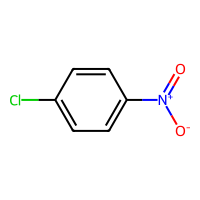

In [11]:
visualised_head(train)

## Преобразование LD50 в логарифмическую шкалу

Для повышения устойчивости модели и устранения перекосов масштаба вычисляется `logLD50` в ммоль/кг.

In [12]:
def logLD50(df):
    logLD50_mmolkg = []
    for i in range(df.shape[0]):
        if pd.isna(df['LD50_mgkg'][i]):
            logLD50_mmolkg.append(df['LD50_mgkg'][i])
        else:
            logLD50_mmolkg.append(math.log10(float(df['LD50_mgkg'][i])/float(df['MW'][i])))
    return logLD50_mmolkg

Добавление logLD50 (ммоль/кг) в тренировочный и тестовый наборы данных

In [13]:
train['logLD50_mmolkg'] = logLD50(train)
test['logLD50_mmolkg'] = logLD50(test)

C:\Users\PC\AppData\Local\Temp\ipykernel_7612\743095266.py:4: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if pd.isna(df['LD50_mgkg'][i]):
C:\Users\PC\AppData\Local\Temp\ipykernel_7612\743095266.py:7: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  logLD50_mmolkg.append(math.log10(float(df['LD50_mgkg'][i])/float(df['MW'][i])))
C:\Users\PC\AppData\Local\Temp\ipykernel_7612\743095266.py:5: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  

Проверка корректности добавления признака logLD50_mmolkg

In [14]:
train.head(1)

,EPA_category,GHS_category,LD50_mgkg,nontoxic,very_toxic,SMILES,ROMol,MW,logLD50_mmolkg
CASRN,,,,,,,,,
100-00-5,2.0,4.0,460.0,False,False,[O-][N+](=O)C1C=CC(Cl)=CC=1,<rdkit.Chem.rdchem.Mol object at 0x0000022A73A...,157.556,0.465323


,EPA_category,GHS_category,LD50_mgkg,nontoxic,very_toxic,SMILES,ROMol,MW,logLD50_mmolkg
CASRN,,,,,,,,,
100-00-5,2.0,4.0,460.0,False,False,[O-][N+](=O)C1C=CC(Cl)=CC=1,,157.556,0.465323

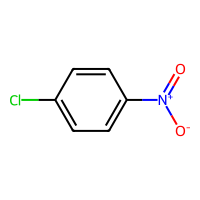

In [15]:
visualised_head(train)

## Преобразование исходных булевых значений nontoxic и very_toxic в бинарные метки:

* toxic = 1, если nontoxic = False;

* verytoxic = 1, если very_toxic = True.

In [16]:
def binary_toxic(df):
    toxic = []
    for i in range(df.shape[0]):
        if pd.isna(df['nontoxic'][i]):
            toxic.append(df['nontoxic'][i])
        else:
            toxic.append(1 if df['nontoxic'][i] is False else 0)
    return toxic

In [17]:
def binary_verytoxic(df):
    verytoxic = []
    for i in range(df.shape[0]):
        if pd.isna(df['very_toxic'][i]):
            verytoxic.append(df['very_toxic'][i])
        else:
            verytoxic.append(0 if df['very_toxic'][i] is False else 1)
    return verytoxic

Создаются новые колонки toxic и verytoxic в обучающем и тестовом наборах.

In [18]:
train['toxic'] = binary_toxic(train)
test['toxic'] = binary_toxic(test)

C:\Users\PC\AppData\Local\Temp\ipykernel_7612\2215102921.py:4: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if pd.isna(df['nontoxic'][i]):
C:\Users\PC\AppData\Local\Temp\ipykernel_7612\2215102921.py:7: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  toxic.append(1 if df['nontoxic'][i] is False else 0)
C:\Users\PC\AppData\Local\Temp\ipykernel_7612\2215102921.py:5: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  toxic.append(df['nontoxic

Проверка структуры набора после добавления новых бинарных меток

In [19]:
train.head(1)

,EPA_category,GHS_category,LD50_mgkg,nontoxic,very_toxic,SMILES,ROMol,MW,logLD50_mmolkg,toxic
CASRN,,,,,,,,,,
100-00-5,2.0,4.0,460.0,False,False,[O-][N+](=O)C1C=CC(Cl)=CC=1,<rdkit.Chem.rdchem.Mol object at 0x0000022A73A...,157.556,0.465323,1.0


,EPA_category,GHS_category,LD50_mgkg,nontoxic,very_toxic,SMILES,ROMol,MW,logLD50_mmolkg,toxic
CASRN,,,,,,,,,,
100-00-5,2.0,4.0,460.0,False,False,[O-][N+](=O)C1C=CC(Cl)=CC=1,,157.556,0.465323,1.0

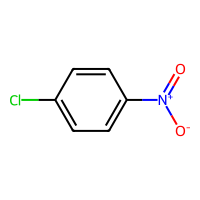

In [20]:
visualised_head(train)

## Очистка набора данных

Удаляются промежуточные столбцы, которые больше не нужны для анализа.

In [21]:
train = train.drop(['nontoxic', 'very_toxic', 'ROMol', 'MW', 'LD50_mgkg'], axis=1)
test = test.drop(['nontoxic', 'very_toxic', 'ROMol', 'MW', 'LD50_mgkg'], axis=1)

Проверка структуры набора после удаления промежуточных признаков

In [22]:
train.head(1)

,EPA_category,GHS_category,SMILES,logLD50_mmolkg,toxic
CASRN,,,,,
100-00-5,2.0,4.0,[O-][N+](=O)C1C=CC(Cl)=CC=1,0.465323,1.0


## Финальное упорядочивание столбцов
Устанавливается логичный порядок колонок, начиная с молекулы и целевых переменных, заканчивая категориальными метками

In [23]:
columnsTitles = ['SMILES', 'logLD50_mmolkg', 'verytoxic', 'toxic', 'EPA_category', 'GHS_category']

In [24]:
train = train.reindex(columns=columnsTitles)
test = test.reindex(columns=columnsTitles)

Проверка итоговой структуры обучающего и тестового наборов

In [25]:
train.head(1)

,SMILES,logLD50_mmolkg,verytoxic,toxic,EPA_category,GHS_category
CASRN,,,,,,
100-00-5,[O-][N+](=O)C1C=CC(Cl)=CC=1,0.465323,NaN,1.0,2.0,4.0


In [26]:
test.head(1)

,SMILES,logLD50_mmolkg,verytoxic,toxic,EPA_category,GHS_category
CASRN,,,,,,
130209-82-4,CC(C)OC(=O)CCCC=CCC1C(O)CC(O)C1CCC(O)CCC1=CC=C...,NaN,NaN,1.0,1.0,1.0


## Сохранение предобработанных наборов

Сохраняем обработанные данные для последующего использования в обучении моделей.

In [27]:
train.to_csv('../data/processed/train_labels.csv')
test.to_csv('../data/processed/test_labels.csv')

## Кодирование категориальных признаков

Создается функция для обучения `LabelEncoder` на всех целевых метках.

In [28]:
def get_labelencoder(df_labels):

    encoder_verytoxic = LabelEncoder().fit(df_labels[~df_labels['verytoxic'].isnull()]['verytoxic'].values)
    encoder_toxic = LabelEncoder().fit(df_labels[~df_labels['toxic'].isnull()]['toxic'].values)
    encoder_epa = LabelEncoder().fit(df_labels[~df_labels['EPA_category'].isnull()]['EPA_category'].values)
    encoder_ghs = LabelEncoder().fit(df_labels[~df_labels['GHS_category'].isnull()]['GHS_category'].values)

    return encoder_verytoxic, encoder_toxic, encoder_epa, encoder_ghs

 Применение функции кодирования к обучающему набору. Теперь категории представлены числами (например, GHS: 1–5)

In [29]:
encoder_verytoxic, encoder_toxic, encoder_epa, encoder_ghs = get_labelencoder(train)

Печать всех уникальных значений (классов), с которыми работали энкодеры

In [30]:
print('Very toxic', encoder_verytoxic.classes_)

Very toxic []


In [31]:
print('Toxic', encoder_toxic.classes_)

Toxic [0. 1.]


In [32]:
print('EPA', encoder_epa.classes_)

EPA [1. 2. 3. 4.]


In [33]:
print('GHS', encoder_ghs.classes_)

GHS [1. 2. 3. 4. 5.]


## Сохранение энкодеров

Каждый энкодер сохраняется в отдельный `.joblib`-файл для использования в пайплайне обработки данных.



In [34]:
joblib.dump(encoder_verytoxic, '../encoder_models/encoder_verytoxic.joblib')
joblib.dump(encoder_toxic, '../encoder_models/encoder_toxic.joblib')
joblib.dump(encoder_epa, '../encoder_models/encoder_epa.joblib')
joblib.dump(encoder_ghs, '../encoder_models/encoder_ghs.joblib')

['../encoder_models/encoder_ghs.joblib']